In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, NMF
from keras.models import Sequential
from keras.layers import (
    Input,
    Dense,
    Dropout,
    LeakyReLU,
)
from keras.initializers import glorot_uniform
from keras.optimizers import Adam

In [13]:
# Load data
features = np.load("face_images.npz")
features = features.get(features.files[0])  # images
features = np.moveaxis(features, -1, 0)
features = features.reshape(features.shape[0], features.shape[1], features.shape[1], 1)
keypoints = pd.read_csv("facial_keypoints.csv")

c:\Users\Zain\AppData\Local\Programs\Python\Python310\lib\_collections_abc.py:819: UserWarning: Reading `.npy` or `.npz` file required additional header parsing as it was created on Python 2. Save the file again to speed up loading and avoid this warning.
  return self[key]


In [14]:
# Clean data
keypoints = keypoints.fillna(0)
new_features = features[keypoints.index.values, :, :, :]  # Nums of rows, w, H, Channels
new_features = new_features / 255
keypoints.reset_index(inplace=True, drop=True)

In [15]:
# Split data
x_train, x_test, y_train, y_test = train_test_split(
    new_features, keypoints, test_size=0.2
)

In [16]:
# Flatten and normalize data
x_train_flat = x_train.reshape(x_train.shape[0], -1)
x_test_flat = x_test.reshape(x_test.shape[0], -1)
x_train_flat /= 255.0
x_test_flat /= 255.0

In [17]:
# PCA
pca = PCA(n_components=100)  # Adjust the number of components as needed
x_train_pca = pca.fit_transform(x_train_flat)
x_test_pca = pca.transform(x_test_flat)

In [18]:
# NMF
nmf = NMF(
    n_components=100, init="random", random_state=0
)  # Adjust the number of components as needed
x_train_nmf = nmf.fit_transform(x_train_flat)
x_test_nmf = nmf.transform(x_test_flat)

c:\Users\Zain\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\decomposition\_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


In [19]:
# Model
img_size = 96
model = Sequential()

model.add(Input(shape=(100,)))  # Use either x_train_pca or x_train_nmf
model.add(Dense(256, kernel_initializer=glorot_uniform()))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.5))

model.add(Dense(64, kernel_initializer=glorot_uniform()))
model.add(LeakyReLU(alpha=0))

model.add(Dense(30, kernel_initializer=glorot_uniform()))

model.summary()
model.compile(loss="mean_squared_error", optimizer=Adam(), metrics=["accuracy"])

c:\Users\Zain\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 256)            │        25,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 30)             │         1,950 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,254 (172.87 KB)

 Trainable params: 44,254 (172.87 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
# Train the model
BATCH_SIZE = 100
EPOCHS = 50
history = model.fit(
    x_train_pca,  # Use either x_train_pca or x_train_nmf
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(x_test_pca, y_test),  # Use either x_test_pca or x_test_nmf
    shuffle=True,
    verbose=1,
)

Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0066 - loss: 1347.9612 - val_accuracy: 0.0028 - val_loss: 1254.4136
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0012 - loss: 1048.8872 - val_accuracy: 0.0028 - val_loss: 570.9608
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0015 - loss: 504.4614 - val_accuracy: 0.0028 - val_loss: 434.5184
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4396 - loss: 416.0204 - val_accuracy: 0.8766 - val_loss: 419.6617
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9014 - loss: 399.6617 - val_accuracy: 0.8766 - val_loss: 416.6854
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8982 - loss: 401.5941 - val_accuracy: 0.8766 - val_loss: 416.2174
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8931 - loss: 401.4282 - val_accuracy: 0.8766 - val_loss: 413.8887
Epoch 8/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8953 - loss: 406.5140 -

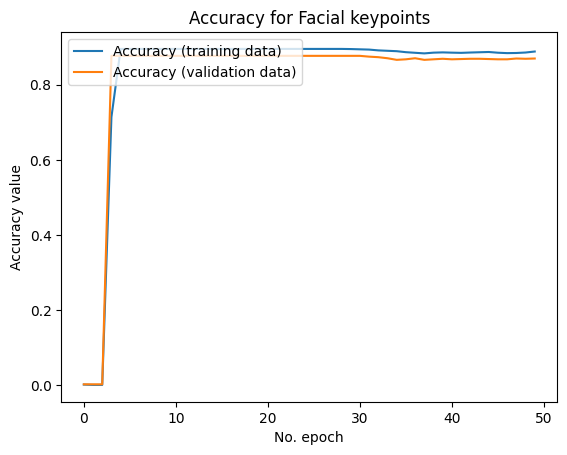

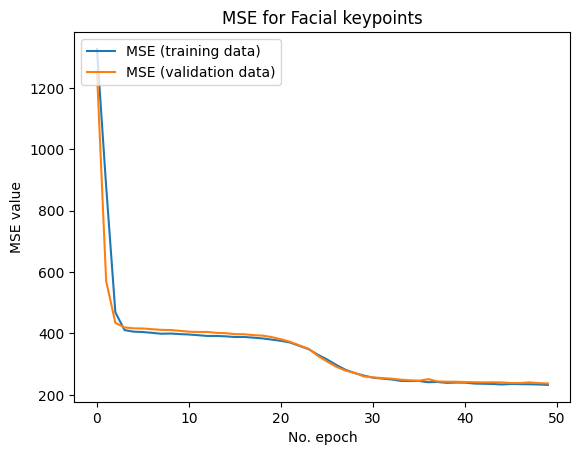

In [21]:
# Plot training history
plt.plot(history.history["accuracy"], label="Accuracy (training data)")
plt.plot(history.history["val_accuracy"], label="Accuracy (validation data)")
plt.title("Accuracy for Facial keypoints")
plt.ylabel("Accuracy value")
plt.xlabel("No. epoch")
plt.legend(loc="upper left")
plt.show()

plt.plot(history.history["loss"], label="MSE (training data)")
plt.plot(history.history["val_loss"], label="MSE (validation data)")
plt.title("MSE for Facial keypoints")
plt.ylabel("MSE value")
plt.xlabel("No. epoch")
plt.legend(loc="upper left")
plt.show()

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


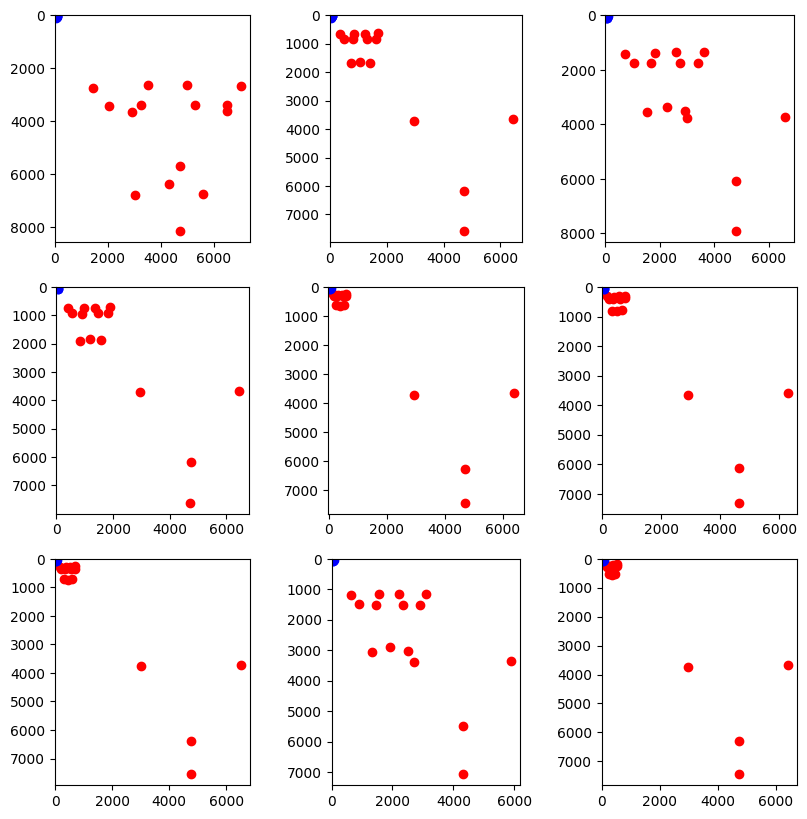

In [22]:
# Make predictions about x_test_pca or x_test_nmf
y_pred = model.predict(x_test_pca)  # Use either x_test_pca or x_test_nmf

# Plot the results
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(x_test[i].reshape(img_size, img_size), cmap="gray")
    ax.scatter(y_pred[i][0::2] * img_size, y_pred[i][1::2] * img_size, c="r")
    ax.scatter(y_test.iloc[i][0::2], y_test.iloc[i][1::2], c="b")
plt.show()